# Reading Order Predictor

In [1]:
import os.path

import csv
import chainer
import cv2
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt

from nltk.translate import bleu

from PIL import Image, ImageDraw, ImageFont, ImageOps
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.utils.metric import type_metric, distance_metric

from kr.classifier.softmax.mobilenetv3 import MobileNetV3
from kr.datasets import KuzushijiUnicodeMapping
from kr.detector.centernet.resnet import Res18UnetCenterNet

In [2]:
class TextScorer:
    def __init__(self, ground_truth_csv='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/ground-truth/full.csv'):
        self.ground_truth_csvfile = ground_truth_csv
        x = []
        self.ground_truth = dict()
        with open(self.ground_truth_csvfile) as cf:
            reader = csv.DictReader(cf)
            for row in reader:
                self.ground_truth[row['image']] = row['text']

    def get_ground_truth(self, image):
        return self.ground_truth.get(image, '')

    def has_ground_truth(self, image):
        if image in self.ground_truth:
            return True
        return False

    def eval(self, image, pred_text):
        ground_truth_text = self.ground_truth.get(image, '')
        if len(ground_truth_text) == 0:
            return -1
        ref = list(ground_truth_text)
        hyp = list(pred_text)
        return  bleu([ref], hyp)

In [3]:
class ColumnClustering:
    def __init__(self, filename, unicodes, unicode_bboxes, reading_order_boxes=None, verbose=True, save=False,
                 save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
        self.filename = filename
        self.unicodes = unicodes
        self.bboxes = unicode_bboxes
        self.text_order_bboxes = reading_order_boxes
        self.verbose = verbose
        self.save = save
        self.save_folder= save_folder

    def _column_clustering(self, data, boxid, max_width, n_clusters=10, merge=False, recursive=False):
        bx = list(data['X'])
        by = list(data['Y'])
        bw = list(data['W'])
        bh = list(data['H'])
        bxy = list(zip(bx, by, bw, bh))

        merge_width = 2*data['W'].std()

        column_size = (max(bx) - min(bx)) / n_clusters
        kmeans_instance = None

        def tolerance_func(p1, p2):
            x1, w1 = p1[0], p1[2]
            x2, w2 = p2[0], p2[2]
            c1 = (x1+w1) / 2
            c2 = (x2+w2) / 2
            if abs(c1 - c2) >= max_width:
                return abs(c1 - c2)
            return 0

        def distance_func(p1, p2):
            return abs(p1[0] - p2[0])

        def merge_clusters(clusters_map, centers_map, df):
            old_to_new_map = dict()
            new_to_old_map = dict()
            new_centers_map = dict()
            cids = list(centers_map.keys())

            if self.verbose:
                print('clusters_map', clusters_map)
                print('centers_map', centers_map)
            
            old_to_new_map[cids[0]] = cids[0]
            new_to_old_map[cids[0]] = [cids[0]]
            new_centers_map[cids[0]] = centers_map[cids[0]]
            if self.verbose:
                print('added a new center {} for cid {}'.format(centers_map[cids[0]], cids[0]))

            # for each original cluster
            for cid1 in cids:
                # find the center of the original cluster
                center1 = centers_map[cid1]
                if cid1 in old_to_new_map:
                    continue
                reassigned = False
                # for each new cluster 
                new_centers_cids = list(new_centers_map.keys())
                for cid2 in new_centers_cids:
                    center2 = new_centers_map[cid2]
                    # compute the distance of the original cluster to the new cluster
                    dist = distance_func(center1, center2)
                    if self.verbose:
                        print('distance between {} and {} is {}, max width to merge {}'.format(cid1, cid2, dist, merge_width))
                    if dist <= merge_width:
                        # if distance is equal or less than a certain threhold
                        if self.verbose:
                            print('merged {} and {}'.format(cid1, cid2))
                        # assign the original cluster to the new cluster
                        old_to_new_map[cid1] = cid2
                        # add the original cluster to the new cluster in the new to old map
                        curr_list = new_to_old_map.get(cid2, [])
                        if cid1 not in curr_list:
                            curr_list.append(cid1)
                        new_to_old_map[cid2] = curr_list                        
                        reassigned = True
                        break
                if not reassigned:
                    # if the cluster is not reassigned
                    if self.verbose:
                        print('adding a new center {} for cid {}'.format(centers_map[cid1], cid1))
                    # make it a new cluster
                    old_to_new_map[cid1] = cid1
                    # update the new to old cluster map
                    new_centers_map[cid1] = centers_map[cid1]
                    curr_list = new_to_old_map.get(cid1, [])
                    if cid1 not in curr_list:
                        curr_list.append(cid1)
                    new_to_old_map[cid1] = curr_list

            if self.verbose:
                print('old_to_new_map', old_to_new_map)
                print('new_to_old_map', new_to_old_map)

            # reassign pts to new clusters and update cluster center
            recomputed_centers_map = dict()
            recomputed_clusters_map = dict()
            for new_cid, center in new_centers_map.items():
                cluster_pts = []
                cluster_pt_ids = []
                # for all old cluster ids that map to new_cid now
                for cid in new_to_old_map[new_cid]:
                    # add them to a data frame
                    cluster_pts.extend([df['X'][row], df['Y'][row]] for row in clusters_map[cid])
                    cluster_pt_ids.extend([row for row in clusters_map[cid]])
                cluster_df = pd.DataFrame(cluster_pts, columns = ['X', 'Y'])
                # compute the new center
                new_center = [cluster_df['X'].mean(), cluster_df['Y'].mean()]
                # update the center for the new cluster
                recomputed_centers_map[new_cid] = new_center
                # update the list of points for the new cluster
                recomputed_clusters_map[new_cid] = cluster_pt_ids

            if self.verbose:
                print('recomputed_clusters_map', recomputed_clusters_map)
                print('recomputed_centers_map', recomputed_centers_map)
            
            return recomputed_clusters_map, recomputed_centers_map

        user_function = lambda point1, point2: tolerance_func(point1, point2) ** 2
        metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

        # create K-Means algorithm with specific distance metric
        start_centers = []
        offset = column_size / 2
        # cluster_y = (max(by) - min(by)) / 2
        for cid in range(n_clusters):
            # randomly initialize the cluster centers
            start_centers.append([max(bx)-offset-(column_size*cid), 0, 0, 0])
            # start_centers.append([random.uniform(min(bx), max(bx)), random.uniform(min(by), max(by)), 0, 0])
        kmeans_instance = kmeans(bxy, start_centers, metric=metric)

        # run cluster analysis and obtain results
        kmeans_instance.process()

        clusters = kmeans_instance.get_clusters()
        centers = kmeans_instance.get_centers()
        clusters_map = {cid: pts for cid, pts in enumerate(clusters)}
        centers_map = {cid: center for cid, center in enumerate(centers)}

        while merge:
            old_cluster_size = len(clusters_map)
            new_clusters_map, new_centers_map = merge_clusters(clusters_map, centers_map, data)
            new_cluster_size = len(new_clusters_map)
            clusters_map = new_clusters_map
            centers_map = new_centers_map
            if not recursive or new_cluster_size == old_cluster_size:
                break

        # if self.verbose:
        #     cluster_fig = kmeans_visualizer.show_clusters(bxy, kmeans_instance.get_clusters(),
        #                                                   kmeans_instance.get_centers())
        #     cluster_fig.savefig('data/preds/clusters_{}_{}'.format(boxid, os.path.basename(filename)))
        #     cimg = Image.open('data/preds/clusters_{}_{}'.format(boxid, os.path.basename(filename)))
        #     cimg = ImageOps.flip(cimg)
        #     plt.imshow(cimg)
        #     if self.save:
        #         plt.savefig('data/preds/clusters_{}_{}'.format(boxid, os.path.basename(filename)))

        return clusters_map, centers_map

    def order_points(self, boxid, data, clusters_map, centers_map):
        centers_list = [(cid, center) for cid, center in centers_map.items()]
        sorted_centers = sorted(centers_list, key=lambda pt: (-pt[1][0], pt[1][1]))
        text = []
        for cid, center in sorted_centers:
            pts = [[data['X'][row], data['Y'][row], data['Char'][row]] for row in clusters_map[cid]]
            sorted_pts = sorted(pts, key=lambda pt: pt[1])
            text.extend([chr(int(pt[2][2:], 16)) for pt in sorted_pts])
        text_str = ''.join(text)
        print('text', boxid, text_str)
        return text_str

    def cluster(self):
        page_text = []
        npoints = []
        pred_clusters = []
        cluster_centers = []
        for boxid, bbox in enumerate(self.text_order_bboxes):
            tx1, ty1, tw, th = bbox
            tx2, ty2 = tx1 + tw, ty1 + th
            points = []
            for (uc, ucbbox) in zip(self.unicodes, self.bboxes):
                cx, cy, cw, ch = ucbbox
                if cx >= tx1 and cy >= ty1 and cw <= tx2 and ch <= ty2:
                    points.append([cx, cy, cw-cx, ch-cy, uc])                
            npoints.append(len(points))
            if len(points) > 0:
                df = pd.DataFrame(points, columns=['X', 'Y', 'W', 'H', 'Char'])        
                print('{} width stats: {} {} {} {}'.format(boxid, df['W'].mean(), df['W'].min(), df['W'].max(), df['W'].std()))
                # max_width=df['W'].min()+df['W'].std()
                max_width = (df['W'].min())/3
                if self.verbose:
                    print('{} max width for clustering: {}'.format(boxid, max_width))
                clusters_map, centers_map = self._column_clustering(df, boxid, max_width, merge=True, recursive=False)
                cluster_centers.extend([(pt[0], pt[1], '{}'.format(cid)) for cid, pt in centers_map.items()])
                box_text = self.order_points(boxid, df, clusters_map, centers_map)
                page_text.append(box_text)
                if self.verbose:
                    cids = list(clusters_map.keys())
                    for cid in cids:
                        pred_clusters.extend([(boxid, cid, df['X'][row], df['Y'][row], df['W'][row], df['H'][row], df['Char'][row]) for row in clusters_map[cid]])
        if self.verbose:
            print('points per cluster', npoints)
            print('total points', len(self.unicodes))
            pred_img = Image.open(self.filename)
            pred_draw = ImageDraw.Draw(pred_img)
            font_path = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf'
            font = ImageFont.truetype(font_path, 80, encoding='utf-8')
            cluster_color='rgb(0,0,0)'
            text_color = 'rgb(255,0,0)'
            box_color = 'rgb(0,0,255)'
            for pt in pred_clusters:
                boxid, cid, x, y, w, h, character = pt[0], pt[1], pt[2], pt[3], pt[4], pt[5], pt[6]
                label = '{}'.format(cid)
                pred_draw.text((x-10, y-10), label, fill=cluster_color, font=font)
                ch = chr(int(character[2:], 16))
                # pred_draw.text((x+12, y-10), ch, fill=text_color, font=font)
                pred_draw.rectangle([(x, y), (x+w, y+h)], outline='blue', width=5)
            for cc in cluster_centers:
                (cx, cy, cid) = cc
                pred_draw.text((cx, cy), cid, fill=text_color, font=font)
            for boxid, bbox in enumerate(self.text_order_bboxes):
                x, y, w, h = bbox
                blabel = 'b{}'.format(boxid)
                pred_draw.rectangle([(x-2, y-2), (x + w + 2, y + h + 2)], outline='blue', width=10)
                pred_draw.text((x+w+10, y+h+10), blabel, fill=box_color, font=font)
            if self.save:
                save_filename = os.path.join(self.save_folder, 'clusters-{}'.format(os.path.basename(self.filename)))
                pred_img.save(save_filename)
            plt.imshow(pred_img)
            plt.title('Predicted clusters for characters in each boxes')
        return ''.join(page_text)

In [4]:
def bbox_scale(bbox, orig_size, new_size):
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
    scale_factor_x = (1.0 * new_size[0]) / orig_size[0]
    scale_factor_y = (1.0 * new_size[1]) / orig_size[1]
    return x * scale_factor_x, y * scale_factor_y, w * scale_factor_x, h * scale_factor_y


class KuzushijiReadingOrderPredictor:
    def __init__(self,
                 detector_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/detector/model_700.npz',
                 classifier_model='/home/ec2-user/code/t-hanya/kuzushiji-recognition/results/classifier/model_1000.npz',
                 font_path='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/font/NotoSansCJKjp-Regular.otf',
                 save_folder='/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/preds'):
        self.detector = detector_model
        self.classifier = classifier_model
        self.save_folder = save_folder
        os.makedirs(self.save_folder, exist_ok=True)

        self.text_color = 'rgb(0,0,0)'
        self.font_path = font_path
        self.font = ImageFont.truetype(self.font_path, 80, encoding='utf-8')

    def predict(self, filename, text_order_bboxes, show_intermdiate_results=True):
        ocr_filename, unicodes, bboxes = self._ocr(filename)
        if show_intermdiate_results:
            self.show_text_order_bboxes(filename, ocr_filename, text_order_bboxes)
        text = self._cluster(filename, ocr_filename, text_order_bboxes, unicodes, bboxes)
        return text

    def _ocr(self, filename):
        # unicode <-> unicode index mapping
        mapping = KuzushijiUnicodeMapping()

        # load trained detector
        detector = Res18UnetCenterNet()
        chainer.serializers.load_npz(self.detector, detector)

        # load trained classifier
        classifier = MobileNetV3(out_ch=len(mapping))
        chainer.serializers.load_npz(self.classifier, classifier)

        # load image
        image = Image.open(filename)

        # character detection
        bboxes, _ = detector.detect(image)

        # character classification
        unicode_indices, _ = classifier.classify(image, bboxes)
        unicodes = [mapping.index_to_unicode(idx) for idx in unicode_indices]

        return self._save_ocr_image(filename, unicodes, bboxes), unicodes, bboxes

    def _save_ocr_image(self, orig_filename, unicodes, bboxes,
                        rewrite=True,
                        limit=-1):
        ocr_file = os.path.join(self.save_folder, os.path.basename(orig_filename))
        if not rewrite and os.path.exists(ocr_file):
            return
        cv2img = cv2.imread(orig_filename)
        n, m = cv2img.shape[0], cv2img.shape[1]
        pred_image = Image.new('RGB', (m, n), color=(255, 255, 255, 127))
        pred_draw = ImageDraw.Draw(pred_image)
        limit = len(bboxes)
        for (ch, bbox) in zip(unicodes[:limit], bboxes[:limit]):
            x, y, w, h = bbox_scale(bbox, (n, m), (n, m))
            pred_draw.text((x, y), chr(int(ch[2:], 16)), fill=self.text_color, font=self.font)
        cv2ocr = np.array(pred_image)
        # cv2ocr = cv2.resize(cv2ocr, (3000, 2000))
        cv2.imwrite(ocr_file, cv2ocr)
        pred_image.close()
        return ocr_file

    def show_text_order_bboxes(self, orig_filename, ocr_filename, text_order_bboxes):
        plt.subplot(1, 2, 1)
        img = Image.open(ocr_filename)
        plt.imshow(img)
        plt.title('ocr image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        img = Image.open(orig_filename)
        draw = ImageDraw.Draw(img)
        for bbox in text_order_bboxes:
            x, y, w, h = bbox
            draw.rectangle([(x, y), (x + w, y + h)], outline='blue', width=10)
        plt.imshow(img)
        plt.title('User provided Bboxes for reading order')
        plt.axis('off')
        save_filename = os.path.join(self.save_folder, 'user_boxes_{}'.format(os.path.basename(orig_filename)))
        img.save(save_filename)


    def _cluster(self, filename, ocr_filename, text_order_bboxes, unicodes, bboxes):
        cc = ColumnClustering(filename, unicodes, bboxes, reading_order_boxes=text_order_bboxes, verbose=True, save=True)
        return cc.cluster()

In [5]:
predictor = KuzushijiReadingOrderPredictor()

In [6]:
def ordered_bboxes(bbox_dict):
    order_list = []
    bbox_list = []
    for k, v in bbox_dict.items():
        order_list.append(float(k))
        bboxes_str = v.split(',')
        x, y, w, h = float(bboxes_str[0]), float(bboxes_str[1]), float(bboxes_str[2]), float(bboxes_str[3])
        bbox_list.append((k, x, y, w, h))
    sorted_bboxes = sorted(bbox_list, key=lambda b: int(b[0]))
    return [(int(b[1]), int(b[2]), int(b[3]), int(b[4])) for b in sorted_bboxes]

3918 2534
[(97, 706, 2106, 2808)]
0 width stats: 68.80058492863333 17.167341126845486 122.93823869411767 24.207224145280136
0 max width for clustering: 5.7224470422818285
clusters_map {0: [13, 18, 21, 31, 33, 56, 58, 75, 81, 85, 87, 97, 118, 127, 129, 132, 134, 135, 137, 138, 158, 159, 168, 175, 176, 179, 183, 186, 199, 200, 204, 217, 230, 231, 232, 239, 245, 248, 255, 257, 267, 268, 271, 277, 278, 287, 288, 294, 307, 308, 311, 314, 321, 323, 324, 326, 332, 339, 346, 352, 367, 368, 369, 377], 1: [1, 32, 54, 59, 63, 71, 76, 79, 82, 89, 110, 124, 128, 130, 136, 169, 180, 189, 225, 234, 235, 237, 242, 253, 262, 269, 275, 281, 284, 285, 330, 335], 2: [11, 17, 40, 53, 55, 67, 95, 99, 107, 117, 121, 143, 154, 173, 194, 201, 203, 209, 213, 227, 228, 238, 261, 265, 292, 313, 328, 338, 342, 343, 350, 363, 374, 379], 3: [8, 15, 23, 24, 41, 47, 60, 64, 68, 70, 72, 108, 115, 119, 142, 148, 215, 216, 222, 224, 247, 252, 273, 295, 336, 357, 372, 373, 380], 4: [0, 2, 20, 22, 25, 30, 36, 73, 78, 101, 

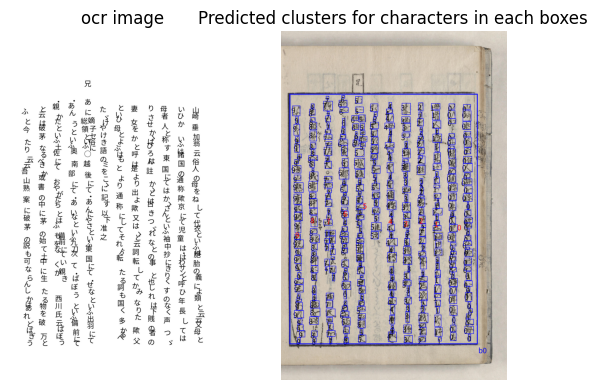

In [14]:
# filename = '/home/ec2-user/code/t-hanya/kuzushiji-recognition/data/new_images/image1.jpeg'
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021763/images/200021763_00016_1.jpg'
# working below 2 lines
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021637/images/200021637_00006_1.jpg'
# bbox_dict = {"1":"1430,198,188,524","2":"824,200,600,516","3":"81,195,747,517","4":"1437,981,180,959","5":"827,721,610,476","6":"830,1205,604,456","7":"837,1674,593,473","8":"841,2156,603,465","9":"648,1026,176,1102","10":"85,721,569,469","11":"85,1204,558,468","12":"93,1679,560,457","13":"96,2156,563,467"}
# bbox_dict = {"2":"829,200,608,513", "5":"822,715,615,480","6":"830,1204,609,461"}
# bbox_dict = {"10":"74,719,577,468"}
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/200021637/images/200021637_00018_2.jpg'
filename = '/home/ec2-user/code/restor-ai-tion/data/full/brsk00000/images/brsk001_020.jpg'
bbox_dict = {"1":"97.9921875,706,2106,2808"}
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00002_2.jpg'
# bbox_dict = {"1":"133.0008544921875,910.001220703125,1947.0125732421875,2716.017578125"}
# working below 5 lines
# filename = '/home/ec2-user/code/restor-ai-tion/data/full/100241706/images/100241706_00003_1.jpg'
# # 100241706_00003_1
# bbox_dict = {"1":"2044.6380615234375,933.426025390625,194.4637451171875,2741.93896484375","2":"1769.6107177734375,925.0918579101562,194.4637451171875,2769.7196655273438","3":"1458.46875,927.8699340820312,230.5784912109375,2741.9389038085938","4":"1211.221923828125,925.0918579101562,197.2418212890625,2733.6049194335938","5":"936.1946411132812,916.7576904296875,183.35150146484375,2733.6048583984375","6":"669.50146484375,925.0918579101562,177.79547119140625,2730.8268432617188","7":"355.5814208984375,916.7576904296875,213.91009521484375,2728.0487060546875"}
# # whole image as 1 bbox for 100241706_00003_1
# bbox_dict = {"1":"322.0020751953125,890.0009765625,1981.0128173828125,2779.017822265625"}
cv2img = cv2.imread(filename)
n, m = cv2img.shape[0], cv2img.shape[1]
print(n, m)

# bbox_dict= {"1":"493,43,74,776","2":"410,43,71,772","3":"337,46,67,770","4":"267,44,62,772","5":"194,43,65,771","6":"119,48,66,762","7":"50,37,57,451"}
# bbox_dict = {"1":"29.853092193603516,627.0526733398438,2486.3136558532715,1700.0095825195312","2":"29.853092193603516,2374.837646484375,2492.2855796813965,1387.478515625"}
# bbox_dict = {"1":"1441.6787109375,210.78732299804688,178.2584228515625,512.6556091308594","2":"1445.5821533203125,1020.1065673828125,165.2469482421875,913.4117431640625","3":"848.3514404296875,206.8838653564453,564.701904296875,495.74058532714844","4":"835.33984375,723.4429321289062,590.7249755859375,452.80242919921875","5":"840.5444946289062,1200.96728515625,585.5203247070312,443.6943359375","6":"841.8456420898438,1675.889404296875,579.0145874023438,450.199951171875","7":"843.1467895507812,2156.01611328125,589.4238891601562,452.80224609375","8":"83.27149963378906,202.9803924560547,737.7556610107422,497.0417022705078","9":"660.9849243164062,1022.7088623046875,174.35491943359375,1087.7667236328125","10":"88.47612762451172,719.5394287109375,560.7984085083008,469.717529296875","11":"96.28306579589844,1208.7742919921875,538.6787261962891,444.9954833984375","12":"94.9819107055664,1679.7928466796875,551.6902694702148,454.1036376953125","13":"98.8853759765625,2158.618408203125,554.2926025390625,473.620849609375"}
# bbox_dict = {"1":"1440.254638671875,206.63638305664062,177.707275390625,514.5245666503906","2":"832.74365234375,200.43728637695312,599.2454833984375,522.7900695800781","3":"76.45447540283203,192.1718292236328,745.9573287963867,518.6573333740234","4":"1448.52001953125,1018.7173461914062,167.37548828125,905.0673217773438","5":"828.6109008789062,723.2273559570312,611.6437377929688,466.99822998046875","6":"832.74365234375,1200.557373046875,607.510986328125,456.6663818359375","7":"834.8099975585938,1675.821044921875,595.1127319335938,458.732666015625","8":"841.0090942382812,2155.217529296875,590.9800415039062,462.865478515625","9":"650.9036254882812,1035.248291015625,177.707275390625,1000.1201171875","10":"76.45447540283203,721.1609497070312,570.3163986206055,477.33001708984375","11":"99.18447875976562,1206.7564697265625,545.5200500488281,464.931884765625","12":"99.18447875976562,1682.0201416015625,549.6528015136719,460.7991943359375","13":"99.18447875976562,2155.217529296875,557.9182434082031,466.998046875"}
# bbox_dict = {"1":"99.18447875976562,2155.217529296875,557.9182434082031,466.998046875", "2":"832.74365234375,200.43728637695312,599.2454833984375,522.7900695800781"}
# bbox_dict = {"1":"1549.0836181640625,911.7171630859375,196.7535400390625,2710.2110595703125","2":"1271.9659423828125,908.9459838867188,213.380615234375,2704.6687622070312","3":"1041.958251953125,917.259521484375,149.6435546875,2712.982177734375","4":"720.501708984375,914.4883422851562,188.44000244140625,2704.6686401367188","5":"460.0110778808594,917.259521484375,177.35531616210938,2707.439697265625","6":"152.4104461669922,911.7171630859375,238.3212127685547,2715.7532958984375"}

# bbox_dict = {"1":"2044.6380615234375,933.426025390625,194.4637451171875,2741.93896484375", "2":"1769.6107177734375,925.0918579101562,194.4637451171875,2769.7196655273438"}
# bbox_dict = {"1":"2044.6380615234375,933.426025390625,194.4637451171875,2741.93896484375"}
# user_bboxes = [(10, 0, 2565, 2250), (10, 2300, 2565, 2163)]
user_bboxes = ordered_bboxes(bbox_dict)
print(user_bboxes)
text = predictor.predict(filename, user_bboxes)
print('full text', text)
scorer = TextScorer()
image_name = os.path.basename(filename).replace('.jpg', '')
if scorer.has_ground_truth(image_name):
    print('ground truth', scorer.get_ground_truth(image_name))
    score = scorer.eval(image_name, text)
    print('bleu', image_name, score)
else:
    print('image {} does not have ground truth'.format(image_name))

In [15]:
fixed_text = 'い山ひ崎か垂加い翁ふは、云諸俗国人のの通母称を歟ね京してにて代衣児と童いふはは・胞はわ胎サのン義と呼によひ類年と長云云し、又て母はと母者人と称す東国にてはかゝさんといふ袖中抄にきりくすのなく声つゞりさせかゝはひろはん。註かゝとは古きつゞれなとの事と也しれは下賎の者の妻女をかと呼は是より出よ歟又はゝと云詞転してかみなりた歟父といひ母とよぶはもとより通称にしてそれゟ転たる詞も国く多かるべ、あたにゞ嫡けや子けセ俗きに語○の越ミを後こにゝにて・記あすん以に下やさ准と之いふ東国にて・せなといふ出羽にて・あん総う領とといいふふ奥南部にて・あいなといふ九刀次て・ばぼうといふ備前にて・親かたといふ土佐にておやがたちとはふ備も前をなにていく親かき西川氏云ばぼうと云は破茅なるべきか或書の中に茅の始て土中に生たる物を破万とふと今たり云云吾山熟案に破茅の説も可ならんしかはあれどばぎう'
scorer.eval('brsk001_020', fixed_text)

0.6179166540234737